# Import Libraries

In [1]:
import gdown
import os
import glob as gb
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, Lambda
from keras.layers import Input, Dense, Activation, Conv2D, MaxPool2D, Flatten
from keras.models import Sequential, Model
from keras.layers import BatchNormalization
from keras.layers import Conv2DTranspose, Concatenate
from keras.callbacks import EarlyStopping

2025-04-29 23:25:46.315888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745969146.585753      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745969146.661836      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load DataSet

In [2]:
train_ds = image_dataset_from_directory('/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Training',
                                                batch_size=32,
                                                seed=200,
                                                image_size=(256,256))
val_ds = image_dataset_from_directory('/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Validation',
                                                batch_size=32,
                                                seed=200,
                                                image_size=(256,256))
test_ds = image_dataset_from_directory('/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Testing',
                                                batch_size=32,
                                                seed=200,
                                                image_size=(256,256))

Found 3251 files belonging to 3 classes.


I0000 00:00:1745969165.919959      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 416 files belonging to 3 classes.
Found 405 files belonging to 3 classes.


In [3]:
# Take one batch from the dataset
for images, labels in train_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)


Images shape: (32, 256, 256, 3)
Labels shape: (32,)


In [4]:
all_labels = []
for _, labels in train_ds:
    all_labels.extend(labels.numpy())

print(set(all_labels))  # to see unique classes


{0, 1, 2}


In [5]:
trainPath=r"/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Training"
for folder in  os.listdir(trainPath ) : 
    files = gb.glob(pathname= str( trainPath +'/' + folder + '/*.jpg'))
    print(f'For training data , found {len(files)} in folder {folder}')

For training data , found 1132 in folder Late_Blight
For training data , found 1303 in folder Early_Blight
For training data , found 816 in folder Healthy


In [6]:
validationPath=r"/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Validation"
for folder in  os.listdir(validationPath ) : 
    files = gb.glob(pathname= str( validationPath +'/' + folder + '/*.jpg'))
    print(f'For training data , found {len(files)} in folder {folder}')

For training data , found 151 in folder Late_Blight
For training data , found 163 in folder Early_Blight
For training data , found 102 in folder Healthy


In [7]:
class_names = train_ds.class_names
class_names

['Early_Blight', 'Healthy', 'Late_Blight']

### visualize some of data

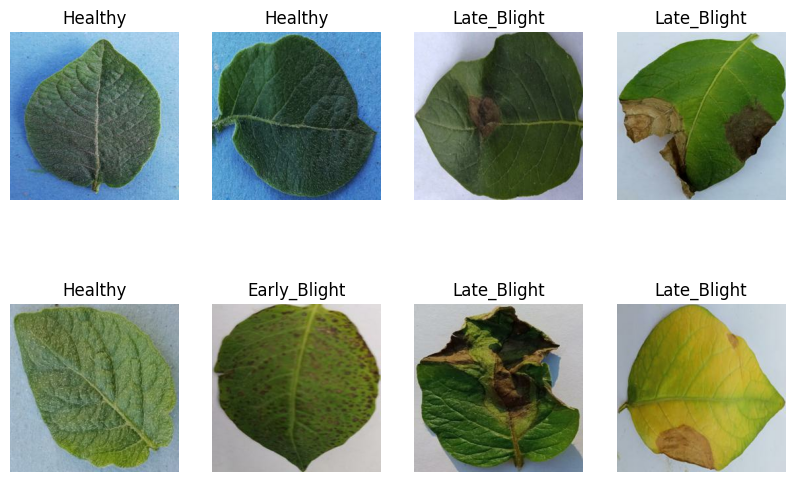

In [8]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in train_ds.take(1):
    for i in range(0,8):
        plt.subplot(3,4,i+1)
        plt.imshow(np.array(image_batch[i]).astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:

scale = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1.0/255)
])

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('vertical'),
  tf.keras.layers.RandomRotation(0.2),
])

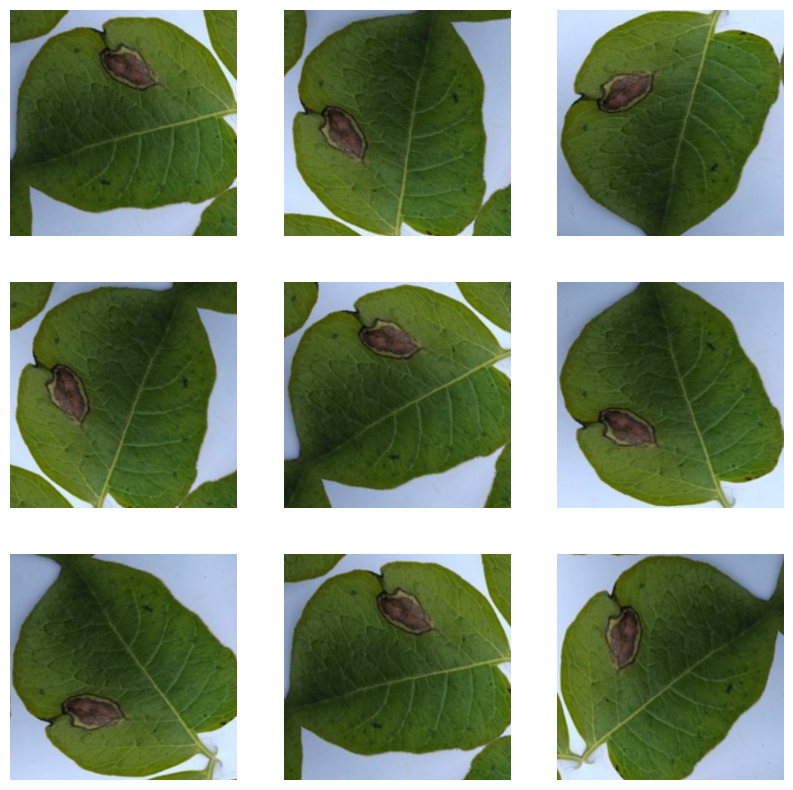

In [11]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [12]:
input_shape = (32, 256, 256, 3)

# CNN Model

In [13]:
input_layer = tf.keras.Input(shape=(256, 256, 3)) 

model = tf.keras.Sequential([
    input_layer,
    scale,
    data_augmentation,

    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(len(class_names),activation='softmax'),
])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297,219 (1.13 MB)

 Trainable params: 297,219 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [15]:
history=model.fit(
    train_ds,
    epochs=30,
    batch_size=64,
   
    validation_data=val_ds
)

Epoch 1/30


I0000 00:00:1745969180.218530      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


102/102 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.4387 - loss: 1.0556 - val_accuracy: 0.4663 - val_loss: 0.9471
Epoch 2/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.6237 - loss: 0.8653 - val_accuracy: 0.6731 - val_loss: 0.7025
Epoch 3/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.7344 - loss: 0.6448 - val_accuracy: 0.7404 - val_loss: 0.6680
Epoch 4/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.7887 - loss: 0.5301 - val_accuracy: 0.8534 - val_loss: 0.3659
Epoch 5/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8701 - loss: 0.3580 - val_accuracy: 0.8990 - val_loss: 0.2909
Epoch 6/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.8614 - loss: 0.3429 - val_accuracy: 0.9014 - val_loss: 0.2531
Epoch 7/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9255 - loss: 0.2036 - val_accuracy: 0.9062 - val_loss: 0.2723
Epoch 8/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9456 - loss: 0.1683 - val_accuracy: 0.95

### plot accuracy and loss

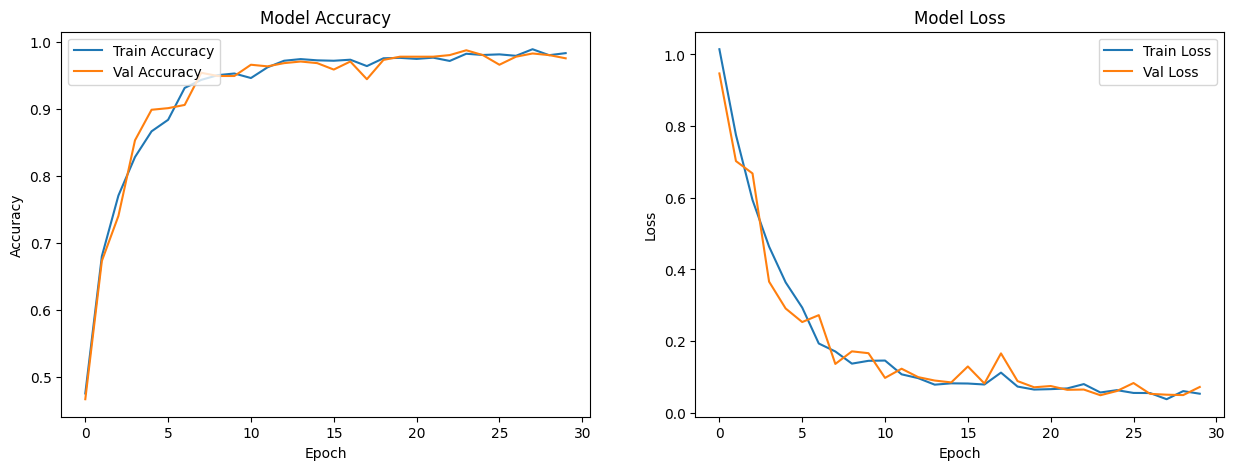

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'],    label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'],    label='Train Loss')
plt.plot(history.history['val_loss'],label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

## CNN Evaluation

In [17]:
model.evaluate(train_ds)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9856 - loss: 0.0446


[0.0419444777071476, 0.9870808720588684]

In [18]:
model.evaluate(val_ds)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9785 - loss: 0.0797


[0.07183905690908432, 0.9759615659713745]

In [19]:
model.evaluate(test_ds)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9699 - loss: 0.1272


[0.17176228761672974, 0.9555555582046509]

The Image Title :  Late_Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Model Predicted label :  Late_Blight


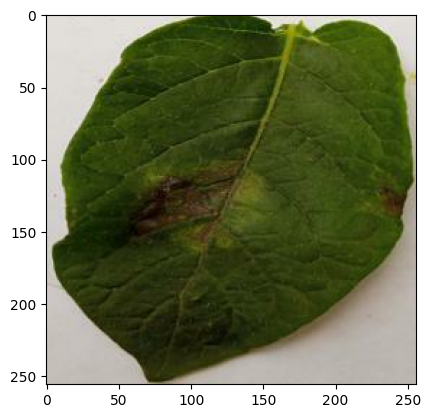

In [20]:
for image_batch,label_batch in test_ds.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    print("The Image Title : ",class_names[label_batch[0].numpy()])
    prediction = model.predict(image_batch)
    print("Model Predicted label : ",class_names[np.argmax(prediction[0])])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


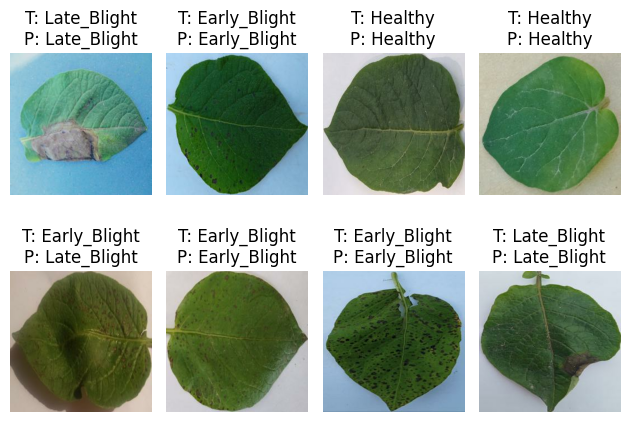

In [21]:
import matplotlib.pyplot as plt
import numpy as np


for image_batch, label_batch in test_ds.take(1):
   
    preds = model.predict(image_batch)  

  
    K = 8
    for i in range(min(K, image_batch.shape[0])):
        img = image_batch[i].numpy().astype("uint8")
        true_label = class_names[label_batch[i].numpy()]
        pred_label = class_names[np.argmax(preds[i])]

        plt.subplot(2, 4, i+1)            
        plt.imshow(img)
        plt.title(f"T: {true_label}\nP: {pred_label}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    break 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


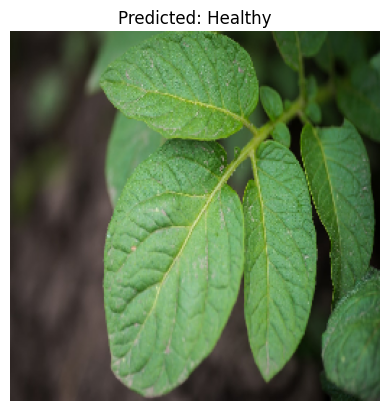

In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image


class_labels = ['Early Blight', 'Healthy', 'Late Blight']


test_folder = '/kaggle/input/potato-leaf'


image_paths = [os.path.join(test_folder, img) for img in os.listdir(test_folder) if img.lower().endswith(('jpg', 'jpeg', 'png'))]

for img_path in image_paths:
  
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # 
    img_array = np.expand_dims(img_array, axis=0)  

    # Predict
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    predicted_label = class_labels[predicted_class]

    # Display result
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()


## Prediction using Pre-trained Models

In [23]:
## from tensorflow.keras.layers import Input, Rescaling, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50,MobileNetV2,VGG19,InceptionV3,EfficientNetB3
from tensorflow.keras.layers import GlobalAveragePooling2D,Dropout

from tensorflow.keras.applications.vgg19 import preprocess_input

IMG_SHAPE = (256, 256, 3)
inputs = Input(shape=IMG_SHAPE)

base_model = VGG19(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = False

x = data_augmentation(inputs)
x = preprocess_input(x)  # VGG19-specific preprocessing
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(len(class_names), activation='softmax')(x)

pre_model = Model(inputs, outputs)
pre_model.summary()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 256, 256, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 256, 256)       │              0 │ sequential_1[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 256, 256)       │              0 │ sequential_1[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 256, 256)       │              0 │ sequential_1[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 256, 256, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256, 256, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg19 (Functional)        │ (None, 8, 8, 512)      │     20,024,384 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 512)            │              0 │ vgg19[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         65,664 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │          4,128 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 3)              │             99 │ dense_3[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 20,094,275 (76.65 MB)

 Trainable params: 69,891 (273.01 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [24]:
pre_model.compile(keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [25]:
pre_history=pre_model.fit(
    x=train_ds,
    epochs=30,
    validation_data=val_ds,
    batch_size=32
)

Epoch 1/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 23s 157ms/step - accuracy: 0.7637 - loss: 0.6001 - val_accuracy: 0.9279 - val_loss: 0.1813
Epoch 2/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 0.9222 - loss: 0.2091 - val_accuracy: 0.9375 - val_loss: 0.1362
Epoch 3/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 0.9297 - loss: 0.1950 - val_accuracy: 0.9447 - val_loss: 0.1330
Epoch 4/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 0.9323 - loss: 0.1774 - val_accuracy: 0.9591 - val_loss: 0.1179
Epoch 5/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 0.9417 - loss: 0.1578 - val_accuracy: 0.9519 - val_loss: 0.1316
Epoch 6/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 0.9582 - loss: 0.1225 - val_accuracy: 0.9327 - val_loss: 0.1959
Epoch 7/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 0.9505 - loss: 0.1564 - val_accuracy: 0.9639 - val_loss: 0.1051
Epoch 8/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 0.9577 - loss: 0

In [26]:
pre_model.evaluate(train_ds)

102/102 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - accuracy: 0.9777 - loss: 0.0625


[0.05503128096461296, 0.980621337890625]

In [27]:
pre_model.evaluate(val_ds)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9801 - loss: 0.0590


[0.07423419505357742, 0.9711538553237915]

In [28]:
pre_model.evaluate(test_ds)

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 288ms/step - accuracy: 0.9672 - loss: 0.0895


[0.08247534930706024, 0.9728395342826843]

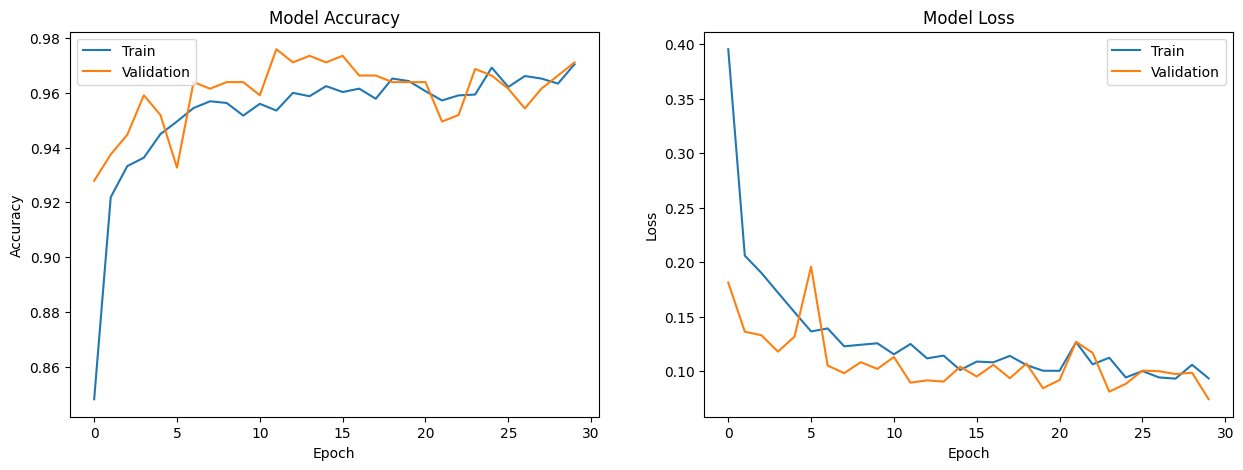

In [29]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(pre_history.history['accuracy'])
plt.plot(pre_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(pre_history.history['loss'])
plt.plot(pre_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'],loc='upper right')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


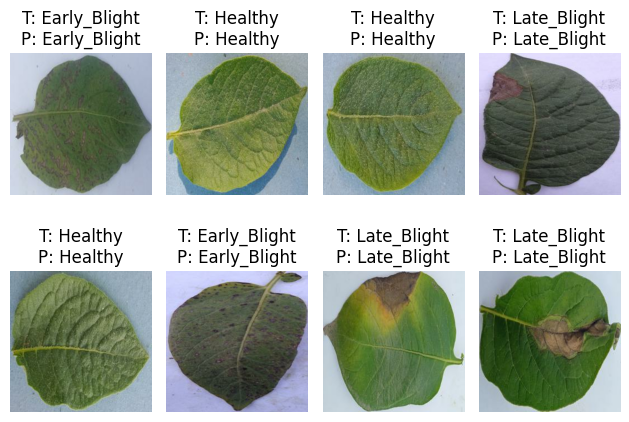

In [30]:
import matplotlib.pyplot as plt
import numpy as np


for image_batch, label_batch in test_ds.take(1):
   
    preds = pre_model.predict(image_batch)  

  
    K = 8
    for i in range(min(K, image_batch.shape[0])):
        img = image_batch[i].numpy().astype("uint8")
        true_label = class_names[label_batch[i].numpy()]
        pred_label = class_names[np.argmax(preds[i])]

        plt.subplot(2, 4, i+1)            
        plt.imshow(img)
        plt.title(f"T: {true_label}\nP: {pred_label}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    break 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


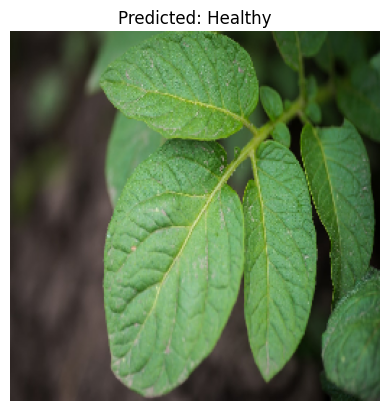

In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input  
from tensorflow.keras.models import load_model  


class_labels = ['Early Blight', 'Healthy', 'Late Blight']  


test_folder = '/kaggle/input/potato-leaf' 

image_paths = [os.path.join(test_folder, img) for img in os.listdir(test_folder) if img.endswith(('jpg', 'jpeg', 'png'))]

for img_path in image_paths:
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = preprocess_input(img_array)  

    # Predict
    prediction = pre_model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    predicted_label = class_labels[predicted_class]

    # Display
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()
